## Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import tqdm
import colored

## Erstelle x und y Kooridnaten
- x_y: x UND y Koordinaten für die Punkte
- c: x UND y Koordinaten für die Zentren

In [8]:
x_y, c = make_blobs(n_samples=5000, centers=7, n_features=2, cluster_std=0.5)

## Startzentren generieren
- Zufällige Auswahl von k Punkten aus x_y als Startzentren
- Wenn möglich sollten die Startzentren mindestend std Abstand voneinander haben

In [9]:
def gen_centers_with_min_distance(k: int, x: np.ndarray, min_dist: float) -> np.ndarray:
    centers = []
    last_index = -1
    while len(centers) < k:
        # Wähle ein zufälliges Zentrum aus den Daten
        if last_index > len(x) - 2:
            centers.append(x[np.random.randint(0, x.shape[0])])
            continue
        candidate = x[last_index+1]
        
        # Überprüfen, ob der neue Kandidat weit genug von allen bestehenden Zentren entfernt ist (min_dist: std)
        if all(np.linalg.norm(candidate - center) > min_dist for center in centers):
            centers.append(candidate)
        last_index += 1
    return np.array(centers)

## K-Means Algorithmus mit gegebenem k

In [10]:
def kmeans_with_k(k: int, x: np.ndarray, max_iterations=1000) -> tuple:
    # Standardabweichung (std) der Daten verwenden
    std = np.std(x)
    initial_centers = gen_centers_with_min_distance(k, x, std)
    centers = initial_centers.copy()
    steps = 0
    
    for _ in tqdm.tqdm(range(max_iterations)):
        steps += 1
        # Berechne die Abstände der Punkte zu den Zentren
        distances = np.array([[np.linalg.norm(x_point - center) for center in centers] for x_point in x])
        # Clusterzuordnung: Jeder Punkt wird dem nächsten Zentrum zugeordnet
        cluster_assignments = np.argmin(distances, axis=1)
        
        # Cluster neu erstellen
        clusters = [x[cluster_assignments == i] for i in range(k)]
        
        # Neue Zentren berechnen
        new_centers = np.array([cluster.mean(axis=0) if len(cluster) > 0 else centers[i] for i, cluster in enumerate(clusters)])
        
        if np.array_equal(centers, new_centers):
            break
        
        # Zentren aktualisieren
        centers = new_centers

    return centers, clusters, steps, initial_centers

#### Plot

In [11]:
def plot_kmeans(k, c, x_y, initial_centers, final_centers, steps, variance):
    # Generate new c with one color per final center
    c = np.array([np.argmin([np.linalg.norm(x_point - center) for center in final_centers]) for x_point in x_y])
    plt.scatter(x_y[:, 0], x_y[:, 1], c=c)
    plt.scatter(initial_centers[:, 0], initial_centers[:, 1], c='red', marker='o', label='Anfangszentren')
    plt.scatter(final_centers[:, 0], final_centers[:, 1], c='blue', marker='o', label='Endzentren')
    plt.legend()
    plt.title(f'K-Means nach {steps} Schritten mit k={k} und Varianz={variance}')
    plt.show()

## Rückgabe des optimalen k (Anzahl der Cluster)

Varianz: 5.9481099465133145


  0%|          | 1/1000 [00:00<00:56, 17.62it/s]


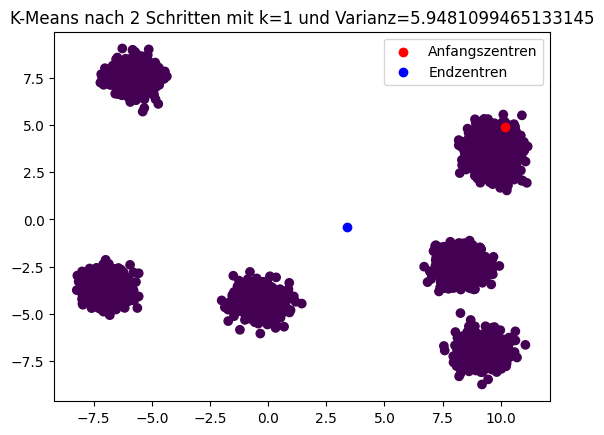

  0%|          | 2/1000 [00:00<00:52, 19.17it/s]


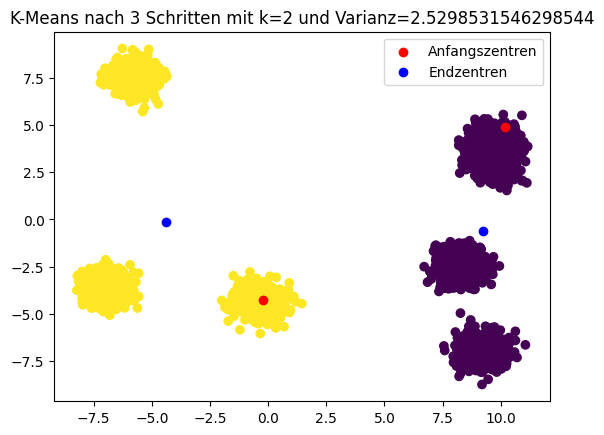

  0%|          | 1/1000 [00:00<01:39, 10.07it/s]


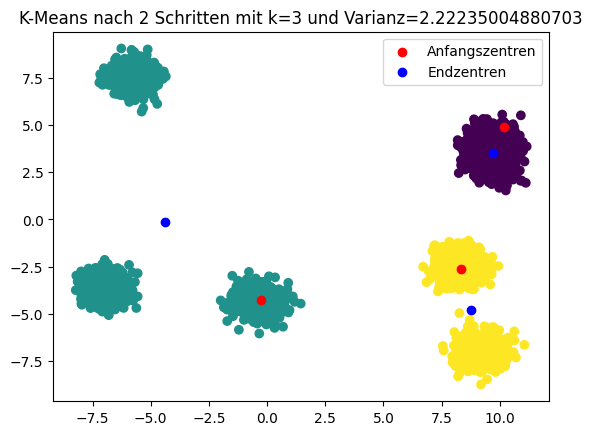

  0%|          | 1/1000 [00:00<02:38,  6.30it/s]


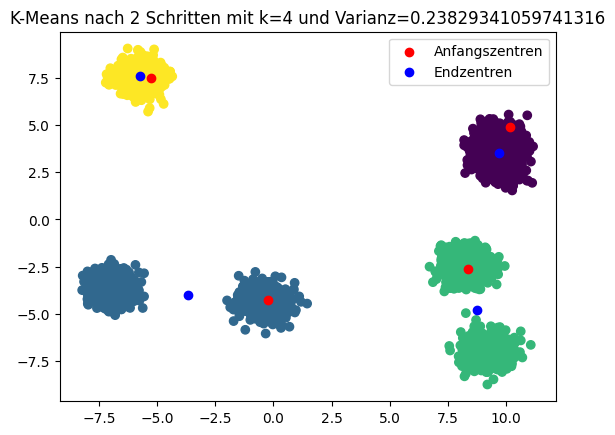

  0%|          | 1/1000 [00:00<03:01,  5.50it/s]


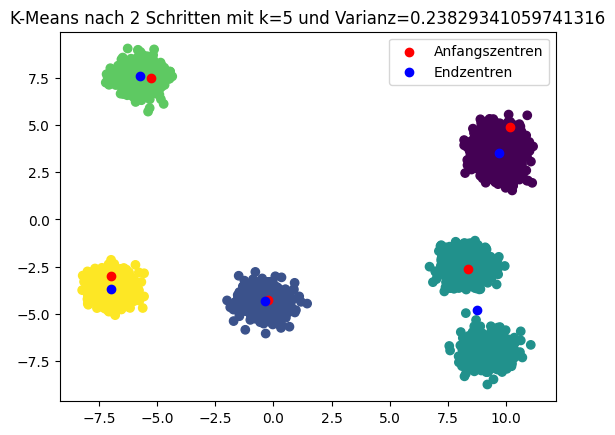

  1%|          | 12/1000 [00:01<01:46,  9.24it/s]


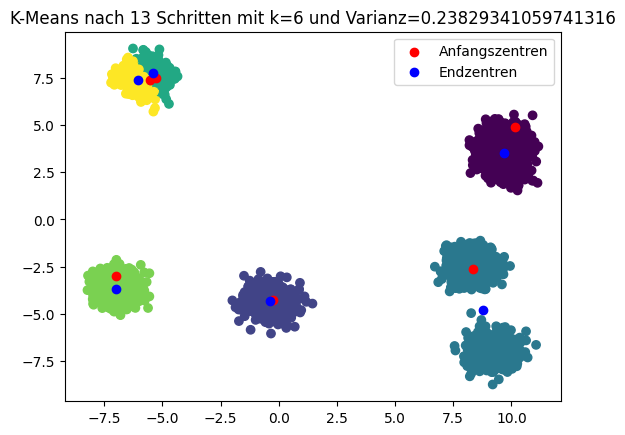

  1%|▏         | 13/1000 [00:01<01:58,  8.31it/s]


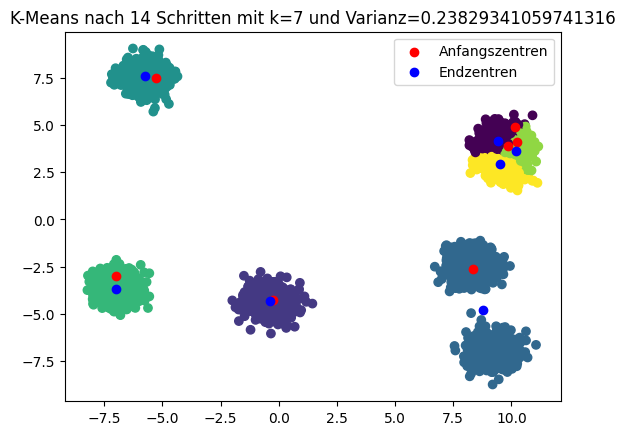

  1%|▏         | 13/1000 [00:01<02:06,  7.78it/s]


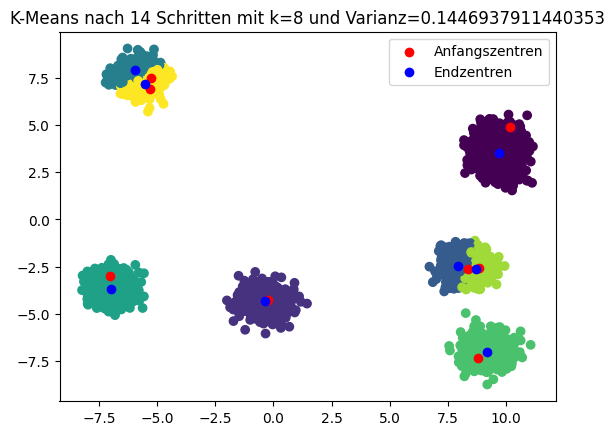

  2%|▏         | 21/1000 [00:03<02:36,  6.25it/s]


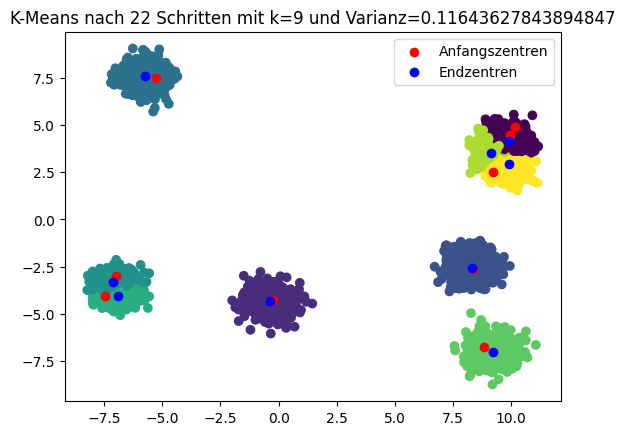

  2%|▏         | 19/1000 [00:03<03:05,  5.29it/s]


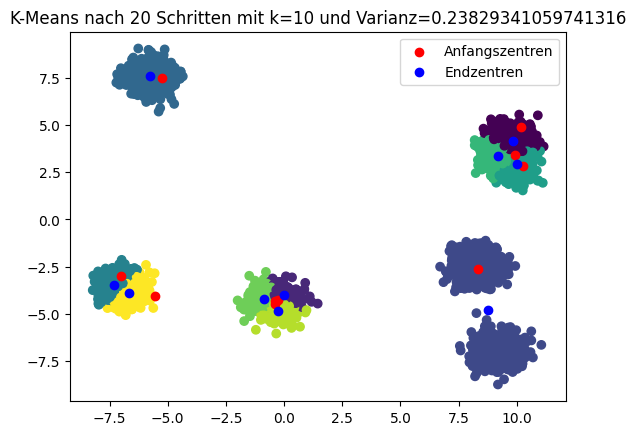

[np.float64(5.9481099465133145), np.float64(2.3761016017184424), np.float64(0.8684457501828261), np.float64(0.17964672392979011), np.float64(0.1380031605037329), np.float64(0.12308032988063762), np.float64(0.1062626619328444), np.float64(0.09637782278045624), np.float64(0.08398489680842808), np.float64(0.08243737852525743)]
[np.float64(2.503306231607069), np.float64(2.7360391840460077), np.float64(4.834186403099863), np.float64(1.301758041439426), np.float64(1.121244642726968), np.float64(1.1582650729982806), np.float64(1.1025634203721877), np.float64(1.1475613645188703), np.float64(1.018772046259289)]
Current k at:  2   2.503306231607069
Current k at:  3   2.7360391840460077
Current k at:  4   4.834186403099863
Current k at:  5   1.301758041439426
 best k at: 6 Change: 1.121244642726968


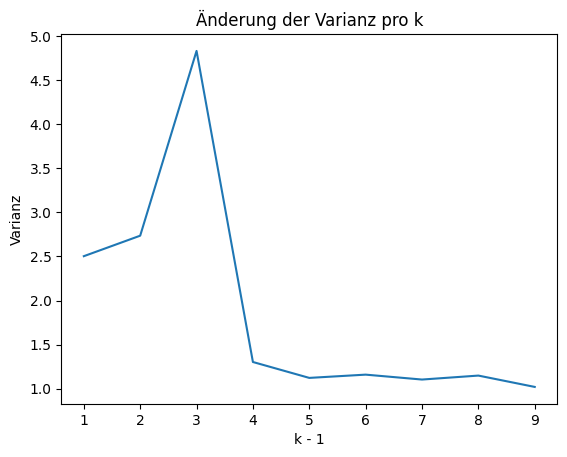

In [12]:
def optimal_k(x: np.ndarray):
    mean_point = x.mean(axis=0)
    distances = np.array([np.linalg.norm(x_point - mean_point) for x_point in x])
    variance = np.var(distances)
    variances_per_k = []    
    change = []
    print(f'Varianz: {variance}')
    for i in range(10):
        centers, clusters, steps, initial_centers = kmeans_with_k(i+1, x)
        in_cluster_variances = np.array([np.var([np.linalg.norm(x_point - center) for x_point in cluster]) for center, cluster in zip(centers, clusters)])
        mean_variance = in_cluster_variances.mean()
        plot_kmeans(i+1, c, x, initial_centers, centers, steps, in_cluster_variances.max())
        if len(variances_per_k) >= 1:
            change.append(variances_per_k[-1]/mean_variance)
        variances_per_k.append(mean_variance)
    print(variances_per_k)
    print(change)
    for k_index in range(len(change)):
        if change[k_index] <= 1.3:
            print(f"{colored.Fore.rgb(0, 255, 0)} best k at: {k_index +2 } Change: {change[k_index]}")
            break
        else:
            print("Current k at: ", k_index +2, " ", change[k_index])
    # Plot variances for each k
    plt.plot(range(1, len(variances_per_k)), change)
    plt.title('Änderung der Varianz pro k')
    plt.xlabel('k - 1')

    plt.ylabel('Varianz')
    plt.show()



optimal_k(x_y)